In [5]:
from __future__ import annotations
import jax
import jax.numpy as jnp

import pyhf
import matplotlib.pyplot as plt

from model import make_model
import relaxed

import jaxopt
import optax


pyhf.set_backend("jax", default=True)


def metrics(
    model: pyhf.Model,
    observed_data: jnp.array,
    diff_pars: jnp.ndarray,
) -> jnp.array:
    cls_obs, bestfit_pars = relaxed.hypotest(
        1.0, observed_data, model, init_pars=jnp.array([0.0, 0.0]), return_mle_pars=True
    )
    cov_approx = relaxed.fisher_info_covariance(bestfit_pars, model, observed_data)
    mu_idx, y_idx = model.config.par_order.index("mu"), model.config.par_order.index(
        "bkguncrt"
    )
    mu_uncert2 = cov_approx[mu_idx, mu_idx]
    pull_width_metric2 = (1 - cov_approx[y_idx, y_idx]) ** 2
    gaussianity = relaxed.model_gaussianity(
        model, bestfit_pars, cov_approx, observed_data
    )

    return dict(
        cls_obs=cls_obs,
        mu_uncert2=mu_uncert2,
        pull_width_metric2=pull_width_metric2,
        gaussianity=gaussianity,
    )


def pipeline(pars: jnp.array, data: jnp.array) -> jnp.array:
    model = make_model(pars)
    all_data = jnp.concatenate((data, jnp.array(model.config.auxdata)))
    return jnp.array(list(metrics(model, all_data, pars).values()))

In [6]:
jax.jacrev(pipeline)(jnp.array([-2.0, -2.0]), data=jnp.array([50.0, 50]))

DeviceArray([[ 0.        ,  0.        ],
             [ 0.        ,  0.        ],
             [ 0.        ,  0.        ],
             [-0.02665937, -0.03569677]], dtype=float64)

In [7]:
def loss(pars):
    #     return jnp.sum(pipeline(pars, jnp.array([50.,50.]))*scale)
    return pipeline(pars, jnp.array([50.0, 50.0]))[0]


jax.value_and_grad(loss)(jnp.array([1.0, 1.0]))

(DeviceArray(0.22561515, dtype=float64), DeviceArray([0., 0.], dtype=float64))

In [8]:
import time

trajectory = []

params = jnp.array([-6.432, 2.0])
trajectory.append(params)

tx = optax.sgd(learning_rate=100)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss)

for i in range(50):
    t0 = time.perf_counter()
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    trajectory.append(params)
    t1 = time.perf_counter()
    print(f"in {t1-t0:.3f}s, loss step {i}: {loss_val:.4f}, pars = {params}")

in 24.085s, loss step 0: 0.2473, pars = [-6.17471958  1.33071556]
in 21.770s, loss step 1: 0.2424, pars = [-5.92009035  0.74789799]
in 23.993s, loss step 2: 0.2386, pars = [-5.67524072  0.24641141]
in 22.157s, loss step 3: 0.2357, pars = [-5.44434502 -0.18402894]
in 25.796s, loss step 4: 0.2335, pars = [-5.22940532 -0.55414955]
in 22.211s, loss step 5: 0.2318, pars = [-5.03105858 -0.87346803]
in 24.899s, loss step 6: 0.2304, pars = [-4.84914082 -1.14997466]
in 25.039s, loss step 7: 0.2294, pars = [-4.6830364  -1.39025765]
in 22.273s, loss step 8: 0.2286, pars = [-4.53188606 -1.59973204]
in 25.111s, loss step 9: 0.2280, pars = [-4.39471294 -1.7828666 ]
in 22.206s, loss step 10: 0.2275, pars = [-4.27049573 -1.94336929]
in 25.073s, loss step 11: 0.2271, pars = [-4.15821503 -2.08433961]
in 22.352s, loss step 12: 0.2268, pars = [-4.05688025 -2.20838582]
in 21.659s, loss step 13: 0.2265, pars = [-3.96554578 -2.317717  ]
in 25.365s, loss step 14: 0.2264, pars = [-3.88331963 -2.41421445]
in 22

In [10]:
jnp.save("traj.npy", jnp.asarray(trajectory))

In [11]:
import numpy as np

dense = 20
num_up, num_down = (dense, dense)

up_grid = np.linspace(-10, 10, num_up)
down_grid = np.linspace(-10, 10, num_down)

uv, dv = np.meshgrid(up_grid, down_grid)

In [14]:
from functools import partial

pipe = partial(pipeline, data=jnp.array([50.0, 50.0]))
values = np.array([pipe(jnp.array(a)) for a in np.vstack([uv.ravel(), dv.ravel()]).T])
np.save("vals.npy", values)

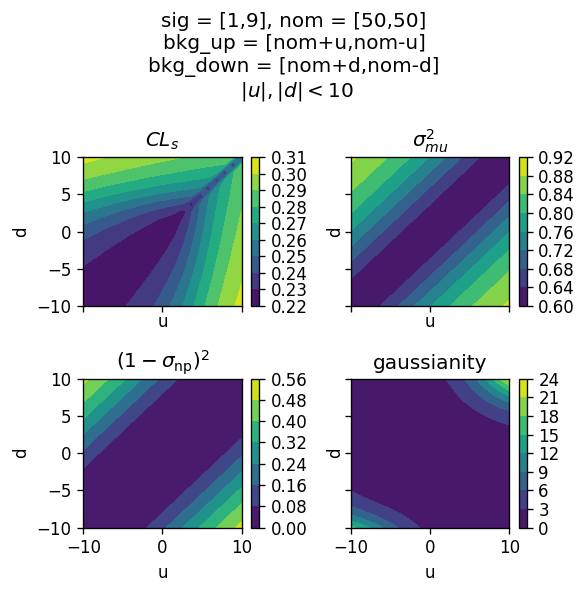

In [18]:
import matplotlib.pyplot as plt

plt.rc("figure", figsize=[5, 5], dpi=120, facecolor="w")

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

for i, (label, ax) in enumerate(
    zip(
        ["$CL_s$", r"$\sigma_{mu}^2$", r"$(1-\sigma_{\mathsf{np}})^2$", "gaussianity"],
        axs.ravel(),
    )
):
    p = ax.contourf(uv, dv, values[:, i].reshape((dense, dense)))
    plt.colorbar(p, ax=ax)
    ax.set_xlabel("u")
    ax.set_ylabel("d")
    ax.set_title(label)

plt.suptitle(
    "sig = [1,9], nom = [50,50]\nbkg_up = [nom+u,nom-u]\nbkg_down = [nom+d,nom-d]\n $|u|, |d|<10$"
)
plt.tight_layout()
plt.savefig("contours.pdf", bbox_inches="tight")